In [4]:
from PIL import Image
import cv2
import numpy as np

In [5]:
input_image = Image.open("astronaut_ldm3d_rgb.jpg")
depth_image = Image.open("astronaut_ldm3d_depth.png")
mask_image = np.zeros_like(np.array(depth_image))
#dummy threshold
mask_image[np.array(depth_image) > 50000] = 65535
mask_image = Image.fromarray(mask_image).convert("L")

In [6]:
depth_image.save("input_depth.png")

In [7]:
from src.diffusers.image_processor import VaeImageProcessorLDM3D

In [8]:
procesor = VaeImageProcessorLDM3D()

In [6]:
depth_image = np.array(Image.open('astronaut_ldm3d_depth.png'))

In [7]:
output = procesor.depthmap_to_rgblike(depth_image)

In [8]:
output.shape

(512, 512, 3)

In [9]:
reverse = procesor.rgblike_to_depthmap(output)

In [10]:
reverse.shape

(512, 512)

In [14]:
reverse[100,100]

12532

In [13]:
depth_image[100,100]

12532

In [11]:
import torch
from PIL import Image
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:

# MIDAS depth estimation
model_type = "DPT_Hybrid"
midas = torch.hub.load("intel-isl/MiDaS", model_type)
midas.to(device)
midas.eval()
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

NameError: name 'torch' is not defined

In [15]:
def estimate_depth(image):
    input_batch = transform(image).to(device)

    with torch.no_grad():
        prediction = midas(input_batch)

        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=image.shape[:2],
            mode="bicubic",
            align_corners=False,
        ).squeeze()

        return prediction

In [16]:
image = np.array(Image.open("astronaut_ldm3d_rgb.jpg"))
prediction = estimate_depth(image)

In [28]:
out = (prediction.cpu().numpy() / prediction.cpu().numpy().max())

In [30]:
out = (out * 65535).astype(np.uint16)

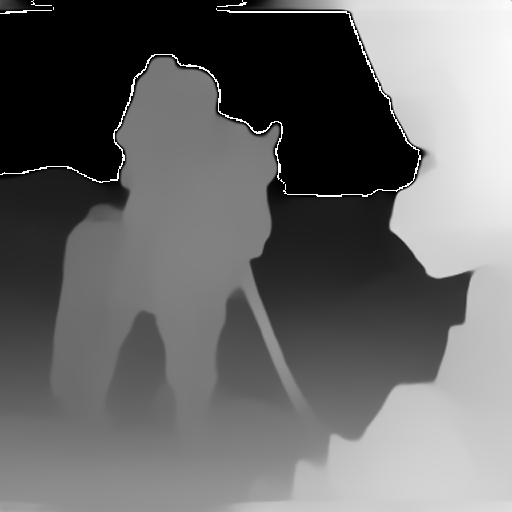

In [31]:
Image.fromarray(out)

In [7]:
from torchvision import transforms

In [86]:
train_transforms = transforms.Compose(
        [
            transforms.Resize(((512,512)), interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.CenterCrop((512,512)) if False else transforms.RandomCrop((512,512)),
            transforms.RandomHorizontalFlip() if True else transforms.Lambda(lambda x: x),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5]),
        ]
    )

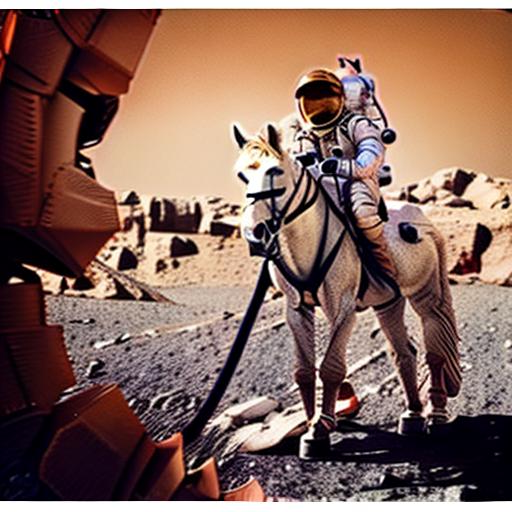

In [87]:
image = Image.open("astronaut_ldm3d_rgb.jpg")
transformed = train_transforms(image)
transformed_img = transformed.permute(1,2,0).numpy()
transformed_img = (transformed_img * 0.5) + 0.5
Image.fromarray((transformed_img * 255).astype(np.uint8))

In [11]:
def estimate_depth(image): 
    input_batch = transform(image).to(device)

    with torch.no_grad():
        prediction = midas(input_batch)

        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=image.shape[:2],
            mode="bicubic",
            align_corners=False,
        ).squeeze()
    
    prediction = (prediction - prediction.min()) / (prediction.max() - prediction.min())\
    
    return prediction[None]

In [67]:
img_in = (transformed_img * 255).astype(np.uint8)

In [73]:
out = estimate_depth(img_in)

In [79]:
out =  out[None]


In [84]:
transformed.Normalize([0.5], [0.5])

AttributeError: 'Tensor' object has no attribute 'Normalize'

In [89]:
from sdinpaint.scripts.generate_llama_mask.saicinpainting.evaluation.masks.mask import SegmentationMask, propose_random_square_crop
from sdinpaint.scripts.generate_llama_mask.saicinpainting.evaluation.utils import load_yaml, SmallMode
from sdinpaint.scripts.generate_llama_mask.saicinpainting.training.data.masks import MixedMaskGenerator

def generate_mask(image):
    mask_generator = SegmentationMask(**config.mask_generator_kwargs)

Detectron v2 is not installed


ModuleNotFoundError: No module named 'saicinpainting'

In [85]:
import cv2
import os
from random import randint, seed

In [81]:
class MaskGenerator():

    def __init__(self, height, width, channels=3, rand_seed=None, filepath=None):
        """Convenience functions for generating masks to be used for inpainting training
        
        Arguments:
            height {int} -- Mask height
            width {width} -- Mask width
        
        Keyword Arguments:
            channels {int} -- Channels to output (default: {3})
            rand_seed {[type]} -- Random seed (default: {None})
            filepath {[type]} -- Load masks from filepath. If None, generate masks with OpenCV (default: {None})
        """

        self.height = height
        self.width = width
        self.channels = channels
        self.filepath = filepath

        # If filepath supplied, load the list of masks within the directory
        self.mask_files = []
        if self.filepath:
            filenames = [f for f in os.listdir(self.filepath)]
            self.mask_files = [f for f in filenames if any(filetype in f.lower() for filetype in ['.jpeg', '.png', '.jpg'])]
            print(">> Found {} masks in {}".format(len(self.mask_files), self.filepath))        

        # Seed for reproducibility
        if rand_seed:
            seed(rand_seed)

    def _generate_mask(self):
        """Generates a random irregular mask with lines, circles and elipses"""

        img = np.zeros((self.height, self.width, self.channels), np.uint8)

        # Set size scale
        size = int((self.width + self.height) * 0.06)
        if self.width < 64 or self.height < 64:
            raise Exception("Width and Height of mask must be at least 64!")
        
        # Draw random lines
        for _ in range(randint(1, 20)):
            x1, x2 = randint(1, self.width), randint(1, self.width)
            y1, y2 = randint(1, self.height), randint(1, self.height)
            thickness = randint(3, size)
            cv2.line(img,(x1,y1),(x2,y2),(1,1,1),thickness)
            
        # Draw random circles
        for _ in range(randint(1, 20)):
            x1, y1 = randint(1, self.width), randint(1, self.height)
            radius = randint(3, size)
            cv2.circle(img,(x1,y1),radius,(1,1,1), -1)
            
        # Draw random ellipses
        for _ in range(randint(1, 20)):
            x1, y1 = randint(1, self.width), randint(1, self.height)
            s1, s2 = randint(1, self.width), randint(1, self.height)
            a1, a2, a3 = randint(3, 180), randint(3, 180), randint(3, 180)
            thickness = randint(3, size)
            cv2.ellipse(img, (x1,y1), (s1,s2), a1, a2, a3,(1,1,1), thickness)
        
        return 1-img

    def _load_mask(self, rotation=True, dilation=True, cropping=True):
        """Loads a mask from disk, and optionally augments it"""

        # Read image
        mask = cv2.imread(os.path.join(self.filepath, np.random.choice(self.mask_files, 1, replace=False)[0]))
        
        # Random rotation
        if rotation:
            rand = np.random.randint(-180, 180)
            M = cv2.getRotationMatrix2D((mask.shape[1]/2, mask.shape[0]/2), rand, 1.5)
            mask = cv2.warpAffine(mask, M, (mask.shape[1], mask.shape[0]))
            
        # Random dilation
        if dilation:
            rand = np.random.randint(5, 47)
            kernel = np.ones((rand, rand), np.uint8) 
            mask = cv2.erode(mask, kernel, iterations=1)
            
        # Random cropping
        if cropping:
            x = np.random.randint(0, mask.shape[1] - self.width)
            y = np.random.randint(0, mask.shape[0] - self.height)
            mask = mask[y:y+self.height, x:x+self.width]

        return (mask > 1).astype(np.uint8)

    def sample(self, random_seed=None):
        """Retrieve a random mask"""
        if random_seed:
            seed(random_seed)
        if self.filepath and len(self.mask_files) > 0:
            return self._load_mask()
        else:
            return self._generate_mask()


In [185]:
mask_gen = MaskGenerator(512, 512, channels=1)

In [178]:
mask = mask_gen.sample()
Image.fromarray(mask*255)

TypeError: Cannot handle this data type: (1, 1, 1), |u1

In [179]:
mask = mask_gen.sample()
mask_torch = torch.from_numpy(mask).float()

In [194]:
def generate_mask():
    mask = mask_gen.sample()
    mask = torch.from_numpy(mask).float()
    return mask.squeeze(2)

In [195]:
mask_bnew = generate_mask()

In [196]:
mask_bnew.shape

torch.Size([512, 512])

In [188]:
Image.fromarray(mask_bnew.squeeze().numpy()*255)

ValueError: Could not save to PNG for display

<PIL.Image.Image image mode=F size=512x512>

In [198]:
image = Image.new("RGB", (512, 512), (0, 0, 0))

In [8]:
train_transforms = transforms.Compose(
        [
            transforms.Resize(512, interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.CenterCrop(512) if True else transforms.RandomCrop(args.resolution),
            transforms.RandomHorizontalFlip() if True else transforms.Lambda(lambda x: x),
            transforms.ToTensor()
            #transforms.Normalize([0.5], [0.5])
        ]
    )

In [5]:
from PIL import Image
image = Image.open("astronaut_ldm3d_rgb.jpg")

In [10]:
image_transform = train_transforms(image)

In [2]:
import torch

In [3]:
# MIDAS depth estimation
model_type = "DPT_Hybrid"
midas = torch.hub.load("intel-isl/MiDaS", model_type)
midas.to("cuda:0")
midas.eval()
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform_midas = midas_transforms.dpt_transform
else:
    transform_midas = midas_transforms.small_transform

Using cache found in C:\Users\Pablo/.cache\torch\hub\intel-isl_MiDaS_master
Using cache found in C:\Users\Pablo/.cache\torch\hub\intel-isl_MiDaS_master


In [56]:
import numpy as np

In [69]:
def estimate_depth(images):
    # Transform back to image to estimate depth, should be a better way to do this (gpu -> cpu -> gpu)
    #images = (images / 2.0) + 0.5 # invert normalize
    images=  [(image.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8) for image in images]
    input_batch = torch.stack([transform_midas(image)[0] for image in images]).to("cuda:0")

    with torch.no_grad():
        prediction = midas(input_batch)
        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=images[0].shape[0:2],
            mode="bicubic",
            align_corners=False,
        )
    # Normalize again
    prediction = (prediction - prediction.min()) / (prediction.max() - prediction.min() ) # Does it need to be -1 to 1?
    
    return prediction

cat = torch.cat([image_transform[None], image_transform[None]], dim=0)
depth = estimate_depth(cat)

In [71]:
image_new = image_transform[None]
depth2 = estimate_depth(image_new)

In [77]:
vis = (depth2[0][0]*255).cpu().numpy().astype(np.uint8)

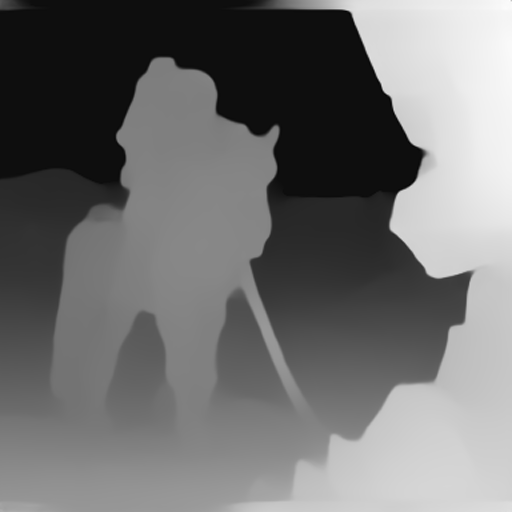

In [78]:
Image.fromarray(vis)

In [70]:
print(cat.shape)
print(image_new.shape)
print(estimate_depth(cat).shape)
print(estimate_depth(image_new).shape)

torch.Size([2, 3, 512, 512])
torch.Size([1, 3, 512, 512])
torch.Size([2, 1, 512, 512])
torch.Size([1, 1, 512, 512])


In [30]:
depth2.shape

torch.Size([512, 1, 512])

Detectron v2 is not installed


ModuleNotFoundError: No module named 'saicinpainting'

In [83]:
mask_generator = MaskGenerator(512, 512, channels=1)

In [93]:
def generate_mask(batch_size=1):
    mask = mask_generator.sample()

    for _ in range(batch_size-1):
        mask_temp = mask_generator.sample()
        mask = np.concatenate((mask, mask_temp), axis=2)

    mask = torch.from_numpy(mask).float()
    mask = np.expand_dims(mask, axis=0).transpose(3, 0, 1, 2)
    return torch.from_numpy(mask).float()

mask = generate_mask(4)

In [91]:
mask = mask_generator.sample()

In [94]:
mask.shape

torch.Size([4, 1, 512, 512])